In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
import os

In [2]:
# 시각화 선명도
%config InlineBackend.figure_format = 'retina' 
# 한글설정 축의 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

In [3]:
movies_processing = pd.read_csv('../프로젝트csv/movies.csv')

In [4]:
# 월_계절 컬럼 만들기
def movie_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

In [5]:
movies_processing['개봉월'] = pd.to_numeric(movies_processing['개봉월'], errors='coerce')
movies_processing['계절'] = movies_processing['개봉월'].apply(movie_season)
movies_processing['계절']

0       4
1       4
2       4
3       4
4       4
       ..
6019    3
6020    2
6021    3
6022    3
6023    2
Name: 계절, Length: 6024, dtype: int64

In [6]:
# 장르2를 만들어 번호와 이름이 같이 출력할수있게 딕셔너리로 변경
movies_genre = {movie:idx   for idx, movie in enumerate(movies_processing['장르'].unique())}
# movies_genre
movies_processing['장르2'] = movies_processing['장르'].map(movies_genre)
print(movies_processing[['장르', '장르2']].head())

      장르  장르2
0  애니메이션    0
1  애니메이션    0
2     액션    1
3    드라마    2
4  애니메이션    0


In [7]:
# 데이터 준비 (분류분석)
# 라벨인코딩 
le = LabelEncoder()
movies_processing['등급_le'] = le.fit_transform(movies_processing['등급'])
movies_processing['관람객수_le'] = le.fit_transform(movies_processing['관람객수'])
movies_processing['계절_le'] = le.fit_transform(movies_processing['계절'])

x = movies_processing[['장르2','총스크린수','관람객수_le', '등급_le']]
y = movies_processing['계절_le']

In [8]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4819, 4), (4819,), (1205, 4), (1205,))

In [9]:
# 데이터 증강
smote = SMOTE(random_state=38, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("비조정 SMOTE", Counter(y_train))
print("조정 SMOTE:", Counter(y_train_smote))

비조정 SMOTE Counter({2: 1298, 1: 1211, 3: 1175, 0: 1135})
조정 SMOTE: Counter({1: 1298, 2: 1298, 0: 1298, 3: 1298})


In [10]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)), # 입력데이터의 colunm 수
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(movies_processing['계절_le'].unique()), activation='softmax')  # 계절의 개수만큼 출력층 생성
])

In [12]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)

# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_up-{epoch:03d}-val{accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               

hist = model.fit(X_train_smote, y_train_smote, 
                 epochs = 500, 
                 validation_split = 0.2, 
                 callbacks = [checkpoint, earlyStopping]
                )

Epoch 1/500
130/130 [==============================] - 2s 6ms/step - loss: 4.9939 - accuracy: 0.2603 - val_loss: 1.3884 - val_accuracy: 0.2377
Epoch 2/500
130/130 [==============================] - 1s 4ms/step - loss: 1.3884 - accuracy: 0.2526 - val_loss: 1.3906 - val_accuracy: 0.2377
Epoch 3/500
130/130 [==============================] - 1s 4ms/step - loss: 1.3896 - accuracy: 0.2596 - val_loss: 1.3928 - val_accuracy: 0.1752
Epoch 4/500
130/130 [==============================] - 1s 5ms/step - loss: 1.3848 - accuracy: 0.2690 - val_loss: 1.3943 - val_accuracy: 0.1752
Epoch 5/500
130/130 [==============================] - 1s 5ms/step - loss: 1.3872 - accuracy: 0.2692 - val_loss: 1.3951 - val_accuracy: 0.1752
Epoch 6/500
130/130 [==============================] - 1s 5ms/step - loss: 1.3881 - accuracy: 0.2678 - val_loss: 1.3959 - val_accuracy: 0.1752
Epoch 7/500
130/130 [==============================] - 1s 5ms/step - loss: 1.3850 - accuracy: 0.2687 - val_loss: 1.3965 - val_accuracy: 0.1752

In [13]:
# 모델 평가하기
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 3ms/step - loss: 1.3917 - accuracy: 0.2531
accuracy : 25.31 %


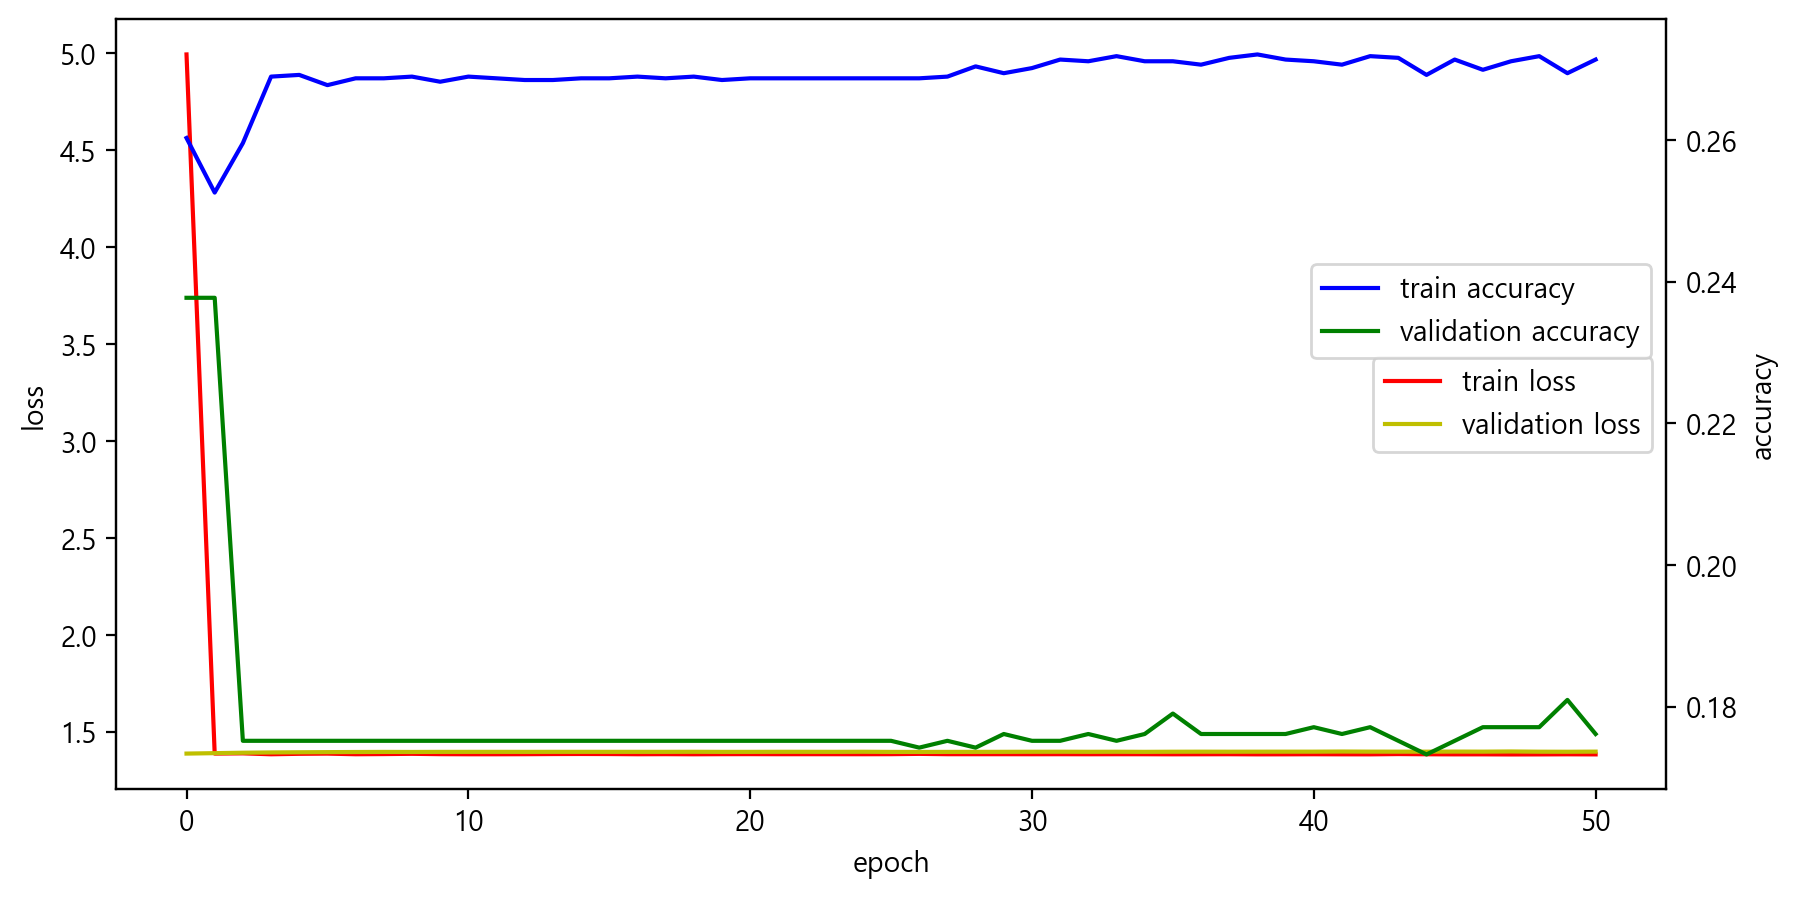

In [14]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

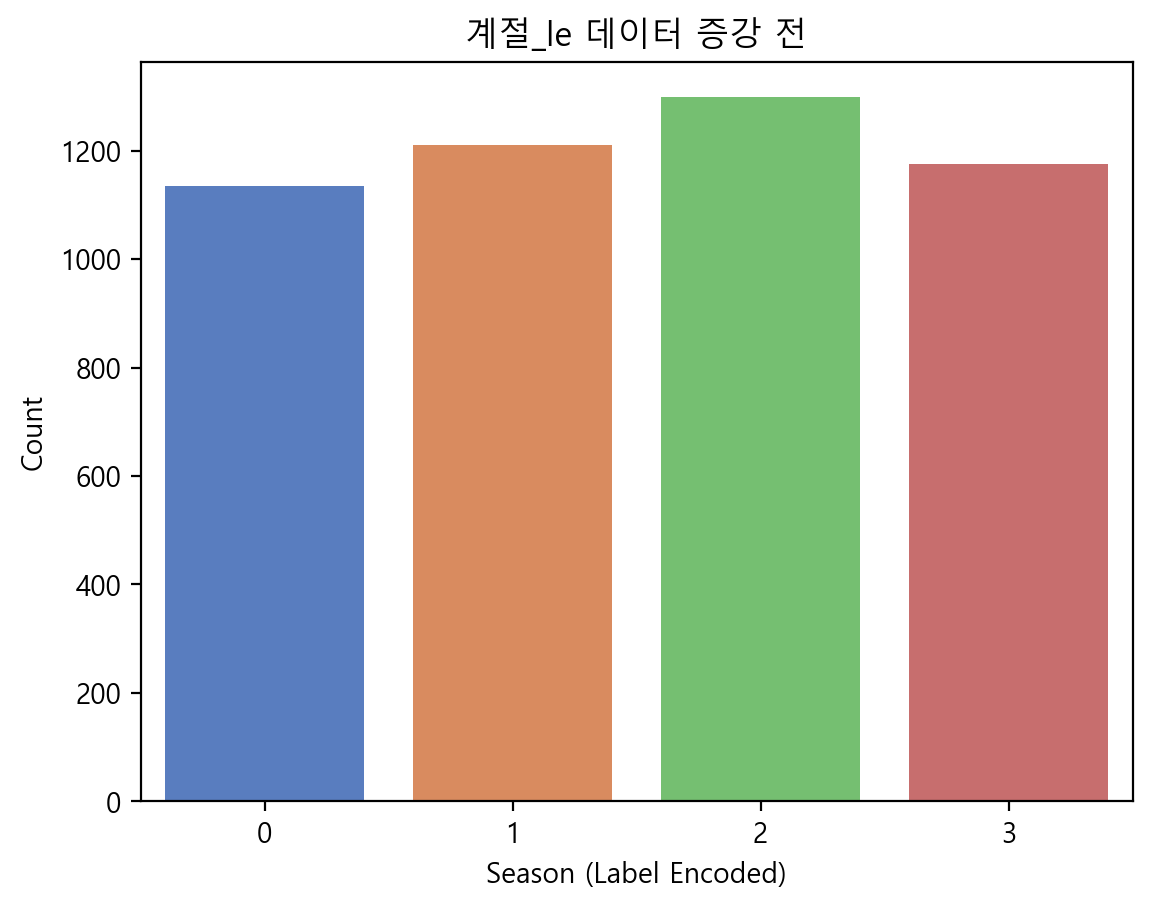

In [15]:
# 데이터 증강 전
sns.countplot(x=y_train, palette='muted')
plt.title('계절_le 데이터 증강 전')
plt.xlabel('Season (Label Encoded)')
plt.ylabel('Count')
plt.show()

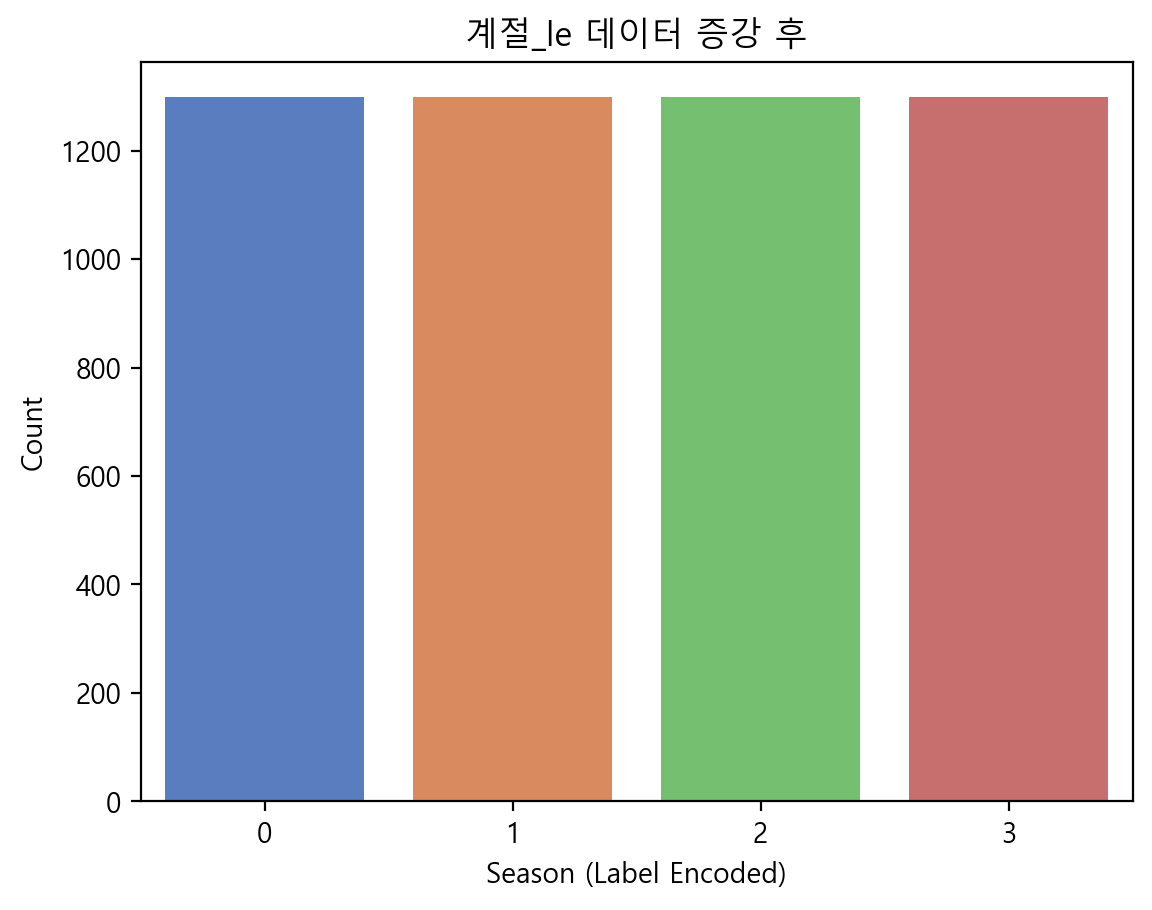

In [16]:
# 데이터 증강 후
sns.countplot(x=y_train_smote, palette='muted')
plt.title('계절_le 데이터 증강 후')
plt.xlabel('Season (Label Encoded)')
plt.ylabel('Count')
plt.show()

In [17]:
movies_processing.to_csv('../프로젝트csv/movies.csv', index=False, encoding='utf-8')